# Benchmark ELEP for phase picking surface events

We will test the ELEP workflow to phase picks the SU events picked by the PNSN.

In [1]:
# import sys
# sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client

import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from geopy import distance
from datetime import datetime
from utils import *
import torch
plt.rcParams.update({'font.size': 10})


import seisbench.models as sbm
device = torch.device("cpu")

from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

In [2]:
# define clients to download the station data
# client = WaveformClient() # we ignore PNWdatastore for now
client2 = Client('IRIS')

t_before = 15 #number of seconds before pick time
# t_after = 15 #number of seconds after pick time
t_before_raw = 1200 #number of seconds before pick time before removing instrumental response
# t_after_raw = 1200 #number of seconds after pick time before removing instrumental response
fs = 40 #sampling rate that all waveforms are resampled to
window = 150 #window length of the signal (this will help with phase picking with EqT next). 
# Use 150 seconds @ 40 Hz gives 6001 points. 
pr = 98 #percentile
thr = 5 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface

# range of dates that we are looking at
t_beginning = UTCDateTime(2001,1,1,0,0,0) 
t_end = UTCDateTime(2023,8,2,23,59)

smooth_length = 5 # constant for smoothing the waveform envelopes
low_cut = 1 #low frequency threshold
high_cut = 12 #high frequency threshold
az_thr = 1000 #threshold of distance in meters from source location
step = 100 #step every 100 m
t_step = 1 #step every second
ratio = 5.6915196 #used to define the grid 
colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3 # radius of the earth

# Read ML models

Make sure that model weights are downloaded for seisbench
```
import os
os.makedirs("/Users/marinedenolle/.seisbench/models/v3/eqtransformer",exist_ok=True)
!wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.pt.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.pt.v1
!wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.json.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.json.v1
```

In [3]:

# ML picker parameters
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05

In [4]:
# download models
pretrain_list = ["pnw","ethz","instance","scedc","stead","geofon","neic"]
pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

In [5]:
pn_pnw_model.to(device);
pn_ethz_model.to(device);
pn_scedc_model.to(device);
pn_neic_model.to(device);
pn_geofon_model.to(device);
pn_stead_model.to(device);
pn_instance_model.to(device);

# Volcano info

In [6]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('../data/station/Volcano_Metadata_50km.csv')

### 3. Surface Event Data from PNSN

Read files straight from PNSN data base. Extract station and network code, phase pick time (seen as start_time). this should be converted to pick_time0.

In [7]:
f1 = pd.read_csv("../data/events/su_picks.txt",sep="|")
f1.head()
print(f1.keys())

Index(['date', 'net', 'sta', 'location', 'seedchan', 'iphase', 'quality',
       'orid', 'etype', 'evid'],
      dtype='object')


In [8]:
# clean up the spaces in the file
format='%Y/%m/%d %H:%M:%S'
test=f1["date"].values.tolist()
start_time_temp = [  datetime.strptime(x.strip(),'%Y/%m/%d %H:%M:%S') for x in f1["date"].values.tolist()]
# # Ignore events prior to t_beginning
ik=np.where(np.array(start_time_temp)>datetime(2001,1,1))[0][0]

# select only net, sta, evid, startime for event past the start date.

start_time = start_time_temp[ik:]
net=[ x.strip() for x in f1["net"].values.tolist()][ik:]
sta=[ x.strip() for x in f1["sta"].values.tolist()][ik:]
evt_id=[ x for x in f1["orid"].values.tolist()][ik:]
all_stas=set(sta)

## download data and phase pick

In [17]:

pick_error = np.zeros(len(evt_id))
from matplotlib.backends.backend_pdf import PdfPages
# pdf = PdfPages('../plots/MLPicks_test.pdf')
for n in range(len(evt_id)): 
    if start_time[n]<datetime(2002,1,1):continue   
    event_ID = str(evt_id[n])
    otime = UTCDateTime(start_time[n])
    networks=net[n]
    stations=sta[n]
    if sta[n]=="LON" or sta[n]=="LO2":continue
    print(event_ID,otime)
    # print(net[n],sta[n])
    try:
        associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
    except: 
        pass
    print(associated_volcano)
    # if associated_volcano!="Mt_Rainier":continue
            
#################### WAVEFORM DOWNLOAD #######################
    #Download all waveforms for that event based on stations and times
    bulk=[[net[n], sta[n], '*', '*H*', otime-t_before_raw, otime+t_before_raw]]
    print(bulk)
    try:
        st = client2.get_waveforms_bulk(bulk)
        st = resample(st,fs)  #resampling the data to 40Hz for each trace
        
        evt_data = obspy.Stream()

        # #Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
        SNR,SNR_weight, no_weight,stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}
        print(st)
        for i,ii in enumerate(st):
            network = ii.stats.network
            station = ii.stats.station
            ii.detrend(type = 'demean')
            ii.filter('bandpass',freqmin=low_cut,freqmax=high_cut,corners=2,zerophase=True)
            cha = ii.stats.channel
            starttime = ii.stats.starttime
            signal_window = ii.copy()
            noise_window = ii.copy()
            # trim the data and noise window to exactly 6000 points
            signal_window.trim(otime - t_before, otime - t_before + window) # trim the signal at the first pick time of the PNSN data, with loose 40s before
            noise_window.trim(otime - window -t_before, otime - t_before) # noise window of the same length
            if not len(signal_window.data) or not len(signal_window.data): continue
            # print(len(signal_window),len(noise_window.data))
            if not np.max(np.percentile(np.abs(signal_window.data),pr)):continue
            if len(noise_window.data)==0:continue
            snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                            / np.percentile(np.abs(noise_window.data),pr))/np.log(10))
            max_amp_time = np.argmax(noise_window.data)/fs
            # print(snr,max_amp_time)
            # signal_window.plot()x
            print(snr,thr)
            if snr<thr: # and 100<max_amp_time<200:
                st.remove(ii)
                continue
            # start the time axis 15 seconds before the pick time of the first reference station
            t = signal_window.times()[:-1] #
            t_diff[network+'.'+station] = starttime-otime 
            stas.append(ii.stats.station)
            nets.append(ii.stats.network)
            SNR.append(snr)
            SNR_weight.append(int(snr))
            no_weight.append(1)
            evt_data.append(signal_window)
            
        sta_available,ind = np.unique(np.array(stas),return_index=True)
        sta_available=sta_available[np.argsort(ind)]
        print(sta_available)
        bigS = np.zeros(shape=(len(sta_available),3,6000))
        stas=[]
        for i in range(len(sta_available)):
            stream = evt_data.select(station=sta_available[i])
            if len(stream[0].data)<6000:continue
            # print("original stream")
            # print(stream)
            if len(stream)<3:
                # copy stream to 2 components, zero the missing data.
                tr3 = stream[0].copy() # assumed to be the vertical
                tr2 = stream[0].copy();tr2.stats.channel=stream[0].stats.channel[0:2]+"N"
                tr1 = stream[0].copy();tr1.stats.channel=stream[0].stats.channel[0:2]+"E"
                tr1.data=np.zeros(len(stream[0].data))
                tr2.data=np.zeros(len(stream[0].data))
                stream=obspy.Stream(traces=[tr1,tr2,tr3])
            # convert Stream into seisbench-friendly array    
            # fill in big array and order data ZNE
            bigS[i,0,:]=stream[2].data[:-1]
            bigS[i,1,:]=stream[1].data[:-1]
            bigS[i,2,:]=stream[0].data[:-1]
            stas.append(sta_available[i])
        print("put data in numpy array")
        # pre process the data
        crap2  = bigS.copy()
        crap2 -= np.mean(crap2,axis=-1,keepdims=True) # demean data
        # original use std norm
        data_std = crap2 / np.std(crap2) + 1e-10
        # could use max data
        mmax= np.max(np.abs(crap2), axis=-1, keepdims=True)
        data_max = np.divide(crap2 ,mmax,out=np.zeros_like(crap2),where=mmax!=0)

        # print(f"Window data shape: {data_std.shape}")

        # evaluate
        pn_pnw_model.eval()
        pn_ethz_model.eval()
        pn_scedc_model.eval()
        pn_neic_model.eval()
        pn_geofon_model.eval()
        pn_stead_model.eval()
        pn_instance_model.eval()
        # convert numpy array to torch tensor
        data_tt = torch.Tensor(data_std)
        # batch predict picks.
        _torch_pred_1 = pn_pnw_model(data_tt.to(device))
        _torch_pred_2 = pn_ethz_model(data_tt.to(device))
        _torch_pred_3 = pn_scedc_model(data_tt.to(device))
        _torch_pred_4 = pn_neic_model(data_tt.to(device))
        _torch_pred_5 = pn_geofon_model(data_tt.to(device))
        _torch_pred_6 = pn_stead_model(data_tt.to(device))
        _torch_pred_7 = pn_instance_model(data_tt.to(device))
        # extract P pdf
        batch_pred =np.zeros(shape=(7,data_std.shape[0],6000))
        batch_pred[0,:, :] = _torch_pred_1[1].detach().cpu().numpy()[:, :]
        batch_pred[1,:, :] = _torch_pred_2[1].detach().cpu().numpy()[:, :]
        batch_pred[2,:, :] = _torch_pred_3[1].detach().cpu().numpy()[:, :]
        batch_pred[3,:, :] = _torch_pred_4[1].detach().cpu().numpy()[:, :]
        batch_pred[4,:, :] = _torch_pred_5[1].detach().cpu().numpy()[:, :]
        batch_pred[5,:, :] = _torch_pred_6[1].detach().cpu().numpy()[:, :]
        batch_pred[6,:, :] = _torch_pred_7[1].detach().cpu().numpy()[:, :]
                    
        # ensemble semblance
        nwin,twin=batch_pred.shape[1],batch_pred.shape[-1]
        print(nwin)
        if nwin==0:continue
        smb_pred = np.zeros([ nwin, twin], dtype = np.float32)
        smb_peak = np.zeros([ nwin], dtype = np.float32)
        for iwin in range(len(stas)):
            # 0 for P-wave
            smb_pred[ iwin, :] = ensemble_semblance(batch_pred[:, iwin, :], paras_semblance)
            imax = np.argmax(smb_pred[ iwin, :80*40]) # search for peak in the first 80 seconds
            if smb_pred[ iwin,imax]>0:
                smb_peak[iwin]=float((imax)/40)
            # smb_peak[iwin] = picks_summary_simple(smb_pred[ iwin, :], thrd = p_thrd)
        # print("check with PNSN picks, relative to reference picks")
        # ista=list(stas).index(sta[n])

        ## plot figure

        # fig = plt.figure()#figsize = (11,8), dpi=200)
        # fig.suptitle(str(otime)+" "+associated_volcano)
        # ax = plt.subplot(1,1,1)
        # iplot = 0
        # for i in range(len(stas)):
        #     ax.plot(t-15,data_max[i,0,:]+iplot*1.5,linewidth=0.5)
        #     ax.plot(t-15,smb_pred[ i, :]/np.max(np.abs(smb_pred[ i, :]))+iplot*1.5,'k',linewidth=0.5)
        #     ax.set_yticks([])
        #     plt.text(-15, iplot*1.5+0.5, stas[i])
        #     # if i==ista:
        #     err_title=("%s %2.2f (s) error in picks"%(stas[i],smb_peak[i]-t_before))
        #     plt.text(60, iplot*1.5+0.5,err_title,color='r')
        #     plt.vlines(smb_peak[i]-t_before,iplot*1.5-1.,iplot*1.5+1.,'r')
        #     print(stas[i],smb_peak[i]-t_before)
        #     iplot+=1
        # # plt.grid(True)
        # ax.set_xlim([-t_before,80])
        # ax.set_xlabel('time (seconds) relative to PNSN picks')
        # plt.show()
        # pdf.savefig(fig)
        # plt.clf()
        # del fig

        pick_error[n] = smb_peak[i]-t_before
        print(pick_error[n] )
    except:
        pass
# pdf.close()

829903 2002-01-01T21:34:50.000000Z
Mt_St_Helens
[['UW', 'YEL', '*', '*H*', UTCDateTime(2002, 1, 1, 21, 14, 50), UTCDateTime(2002, 1, 1, 21, 54, 50)]]
1 Trace(s) in Stream:
UW.YEL..EHZ | 2002-01-01T21:14:50.000000Z - 2002-01-01T21:54:50.000000Z | 40.0 Hz, 96001 samples
22.63218629476427 5
['YEL']
put data in numpy array
1
1.0499992370605469
829903 2002-01-01T21:34:52.000000Z
Mt_St_Helens
[['UW', 'EDM', '*', '*H*', UTCDateTime(2002, 1, 1, 21, 14, 52), UTCDateTime(2002, 1, 1, 21, 54, 52)]]
1 Trace(s) in Stream:
UW.EDM..EHZ | 2002-01-01T21:14:52.000000Z - 2002-01-01T21:54:52.000000Z | 40.0 Hz, 96001 samples
21.93084061433957 5
['EDM']
put data in numpy array
1
0.3000001907348633
830593 2002-01-02T17:38:19.000000Z
Mt_St_Helens
[['UW', 'YEL', '*', '*H*', UTCDateTime(2002, 1, 2, 17, 18, 19), UTCDateTime(2002, 1, 2, 17, 58, 19)]]
29 Trace(s) in Stream:

UW.YEL..EHZ | 2002-01-02T17:18:19.009500Z - 2002-01-02T17:18:23.659500Z | 40.0 Hz, 187 samples
...
(27 other traces)
...
UW.YEL..EHZ | 2002-01

/Users/marinedenolle/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/marinedenolle/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/marinedenolle/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


29 Trace(s) in Stream:

UW.EDM..EHZ | 2002-01-02T17:18:22.009500Z - 2002-01-02T17:18:23.659500Z | 40.0 Hz, 67 samples
...
(27 other traces)
...
UW.EDM..EHZ | 2002-01-02T17:45:27.700100Z - 2002-01-02T17:58:21.975100Z | 40.0 Hz, 30972 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
3.6596317038443535 5
[]
put data in numpy array
0
830623 2002-01-02T20:16:48.000000Z
Mt_Rainier
[['UW', 'RCS', '*', '*H*', UTCDateTime(2002, 1, 2, 19, 56, 48), UTCDateTime(2002, 1, 2, 20, 36, 48)]]
8 Trace(s) in Stream:
UW.RCS..EHZ | 2002-01-02T19:56:48.007700Z - 2002-01-02T20:00:26.582700Z | 40.0 Hz, 8744 samples
UW.RCS..EHZ | 2002-01-02T20:00:27.624000Z - 2002-01-02T20:05:26.574000Z | 40.0 Hz, 11959 samples
UW.RCS..EHZ | 2002-01-02T20:05:27.620600Z - 2002-01-02T20:10:26.570600Z | 40.0 Hz, 11959 samples
UW.RCS..EHZ | 2002-01-02T20:10:27.616900Z - 2002-01-02T20:15:26.566900Z | 40.0 Hz, 11959 samples
UW.RCS..EHZ | 2002-01-02T20:15:27.613100Z - 2002-01-02T20:20:26.563100Z | 40.0 Hz, 119

/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_29423/712426566.py:97: RuntimeWarning: invalid value encountered in divide
  data_std = crap2 / np.std(crap2) + 1e-10


1 Trace(s) in Stream:
UW.HSR..EHZ | 2002-04-08T16:50:33.005700Z - 2002-04-08T17:30:32.980700Z | 40.0 Hz, 96000 samples
12.658753942625953 5
['HSR']
put data in numpy array
1
0.6499996185302734
833748 2002-04-08T17:10:33.000000Z
Mt_Hood
[['UW', 'TDH', '*', '*H*', UTCDateTime(2002, 4, 8, 16, 50, 33), UTCDateTime(2002, 4, 8, 17, 30, 33)]]
1 Trace(s) in Stream:
UW.TDH..EHZ | 2002-04-08T16:50:33.005400Z - 2002-04-08T17:30:32.980400Z | 40.0 Hz, 96000 samples
13.486131681467347 5
['TDH']
put data in numpy array
1
0.5249996185302734
833748 2002-04-08T17:10:38.000000Z
Mt_St_Helens
[['UW', 'YEL', '*', '*H*', UTCDateTime(2002, 4, 8, 16, 50, 38), UTCDateTime(2002, 4, 8, 17, 30, 38)]]
1 Trace(s) in Stream:
UW.YEL..EHZ | 2002-04-08T16:50:38.005400Z - 2002-04-08T17:30:37.980400Z | 40.0 Hz, 96000 samples
13.279977535577146 5
['YEL']
put data in numpy array
1
0.9250001907348633
833778 2002-04-08T20:37:48.000000Z
Mt_St_Helens
[['UW', 'HSR', '*', '*H*', UTCDateTime(2002, 4, 8, 20, 17, 48), UTCDateTime(20

In [ ]:
len(noise_window.data)

0

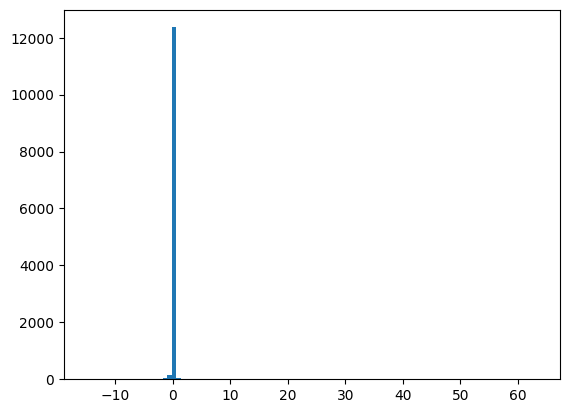

In [ ]:
ik=np.where(np.abs(pick_error)>0)
plt.hist(pick_error[ik],100);

In [ ]:
pdf.close()

In [ ]:
print(n)
print(pick_error.shape)
print(len(evt_id))

12231
(14066,)
14066


In [ ]:
plt.hist(pick_error)

# Multi-band Predictions

In [ ]:
fqmin = 0.1
fqmax = 20
dt = 0.025; fs = 40;
nfqs = 10
nt = 6000; nc = 3;
fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

bandpass filter

In [ ]:
pick_error = np.zeros(len(evt_id))
from matplotlib.backends.backend_pdf import PdfPages
# pdf = PdfPages('../plots/MLPicks_test.pdf')
for n in range(len(evt_id)): 
    if start_time[n]<datetime(2002,1,1):continue   
    event_ID = str(evt_id[n])
    otime = UTCDateTime(start_time[n])
    networks=net[n]
    stations=sta[n]
    if sta[n]=="LON" or sta[n]=="LO2":continue
    print(event_ID,otime)
    # print(net[n],sta[n])
    try:
        associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
    except: 
        pass
    print(associated_volcano)
    # if associated_volcano!="Mt_Rainier":continue
            
#################### WAVEFORM DOWNLOAD #######################
    #Download all waveforms for that event based on stations and times
    bulk=[[net[n], sta[n], '*', '*H*', otime-t_before_raw, otime+t_before_raw]]
    print(bulk)
    try:
        st = client2.get_waveforms_bulk(bulk)
        st = resample(st,fs)  #resampling the data to 40Hz for each trace
        
        evt_data = obspy.Stream()

        # #Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
        SNR,SNR_weight, no_weight,stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}
        for i,ii in enumerate(st):
            network = ii.stats.network
            station = ii.stats.station
            ii.detrend(type = 'demean')
            ii.filter('bandpass',freqmin=low_cut,freqmax=high_cut,corners=2,zerophase=True)
            cha = ii.stats.channel
            starttime = ii.stats.starttime
            signal_window = ii.copy()
            noise_window = ii.copy()
            # trim the data and noise window to exactly 6000 points
            signal_window.trim(otime - t_before, otime - t_before + window) # trim the signal at the first pick time of the PNSN data, with loose 40s before
            noise_window.trim(otime - window -t_before, otime - t_before) # noise window of the same length
            if not len(signal_window.data) or not len(signal_window.data): continue
            # print(len(signal_window),len(noise_window.data))
            if not np.max(np.percentile(np.abs(signal_window.data),pr)):continue
            if len(noise_window.data)==0:continue
            snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                            / np.percentile(np.abs(noise_window.data),pr))/np.log(10))
            max_amp_time = np.argmax(noise_window.data)/fs
            # print(snr,max_amp_time)
            # signal_window.plot()x
            if snr<thr: # and 100<max_amp_time<200:
                st.remove(ii)
                continue
            # start the time axis 15 seconds before the pick time of the first reference station
            t = signal_window.times()[:-1] #
            t_diff[network+'.'+station] = starttime-otime 
            stas.append(ii.stats.station)
            nets.append(ii.stats.network)
            SNR.append(snr)
            SNR_weight.append(int(snr))
            no_weight.append(1)
            evt_data.append(signal_window)
            
        sta_available,ind = np.unique(np.array(stas),return_index=True)
        sta_available=sta_available[np.argsort(ind)]
        print(sta_available)
        bigS = np.zeros(shape=(len(sta_available),3,6000))
        stas=[]
        for i in range(len(sta_available)):
            stream = evt_data.select(station=sta_available[i])
            if len(stream[0].data)<6000:continue
            # print("original stream")
            # print(stream)
            if len(stream)<3:
                # copy stream to 2 components, zero the missing data.
                tr3 = stream[0].copy() # assumed to be the vertical
                tr2 = stream[0].copy();tr2.stats.channel=stream[0].stats.channel[0:2]+"N"
                tr1 = stream[0].copy();tr1.stats.channel=stream[0].stats.channel[0:2]+"E"
                tr1.data=np.zeros(len(stream[0].data))
                tr2.data=np.zeros(len(stream[0].data))
                stream=obspy.Stream(traces=[tr1,tr2,tr3])
            # convert Stream into seisbench-friendly array    
            # fill in big array and order data ZNE
            bigS[i,0,:]=stream[2].data[:-1]
            bigS[i,1,:]=stream[1].data[:-1]
            bigS[i,2,:]=stream[0].data[:-1]
            stas.append(sta_available[i])


        
        print("put data in numpy array")

        nseg = len(sta_available)

        windows_std = np.zeros(shape=(nseg, nfqs, 3, twin), dtype= np.float32)
        windows_max = np.zeros(shape=( nseg, nfqs, 3, twin), dtype= np.float32)
        _windows = np.zeros(shape=( 3, twin), dtype= np.float32)
        _windows_mb = np.zeros(shape=(nseg, 3, nfqs, twin), dtype= np.float32)
        windows_idx = np.zeros(nseg, dtype=np.int32)
        # pre process the data
        crap2  = bigS.copy()
        crap2 -= np.mean(crap2,axis=-1,keepdims=True) # demean data
        # original use std norm
        data_std = crap2 / np.std(crap2) + 1e-10
        # could use max data
        mmax= np.max(np.abs(crap2), axis=-1, keepdims=True)
        data_max = np.divide(crap2 ,mmax,out=np.zeros_like(crap2),where=mmax!=0)

        # print(f"Window data shape: {data_std.shape}")

        # evaluate
        pn_pnw_model.eval()
        pn_ethz_model.eval()
        pn_scedc_model.eval()
        pn_neic_model.eval()
        pn_geofon_model.eval()
        pn_stead_model.eval()
        pn_instance_model.eval()
        # convert numpy array to torch tensor
        data_tt = torch.Tensor(data_std)
        # batch predict picks.
        _torch_pred_1 = pn_pnw_model(data_tt.to(device))
        _torch_pred_2 = pn_ethz_model(data_tt.to(device))
        _torch_pred_3 = pn_scedc_model(data_tt.to(device))
        _torch_pred_4 = pn_neic_model(data_tt.to(device))
        _torch_pred_5 = pn_geofon_model(data_tt.to(device))
        _torch_pred_6 = pn_stead_model(data_tt.to(device))
        _torch_pred_7 = pn_instance_model(data_tt.to(device))
        # extract P pdf
        batch_pred =np.zeros(shape=(7,data_std.shape[0],6000))
        batch_pred[0,:, :] = _torch_pred_1[1].detach().cpu().numpy()[:, :]
        batch_pred[1,:, :] = _torch_pred_2[1].detach().cpu().numpy()[:, :]
        batch_pred[2,:, :] = _torch_pred_3[1].detach().cpu().numpy()[:, :]
        batch_pred[3,:, :] = _torch_pred_4[1].detach().cpu().numpy()[:, :]
        batch_pred[4,:, :] = _torch_pred_5[1].detach().cpu().numpy()[:, :]
        batch_pred[5,:, :] = _torch_pred_6[1].detach().cpu().numpy()[:, :]
        batch_pred[6,:, :] = _torch_pred_7[1].detach().cpu().numpy()[:, :]
                    
        # ensemble semblance
        nwin,twin=batch_pred.shape[1],batch_pred.shape[-1]
        print(nwin)
        if nwin==0:continue
        smb_pred = np.zeros([ nwin, twin], dtype = np.float32)
        smb_peak = np.zeros([ nwin], dtype = np.float32)
        for iwin in range(len(stas)):
            # 0 for P-wave
            smb_pred[ iwin, :] = ensemble_semblance(batch_pred[:, iwin, :], paras_semblance)
            imax = np.argmax(smb_pred[ iwin, :80*40]) # search for peak in the first 80 seconds
            if smb_pred[ iwin,imax]>0:
                smb_peak[iwin]=float((imax)/40)


for iseg in range(nseg):
    for icha in range(3):
        _windows_mb[iseg, icha, :, :] = MB_filter(_windows[iseg, icha], MBF_paras)
_windows_mb = _windows_mb.swapaxes(1, 2)

normalize

In [ ]:
for iseg in tqdm(range(nseg)):
    for ifre in range(nfqs):
        # original use std norm
        windows_std[iseg, ifre, :] = _windows_mb[iseg, ifre, :] / np.std(_windows_mb[iseg, ifre, :]) + 1e-10
        # others use max norm
        windows_max[iseg, ifre, :] = _windows_mb[iseg, ifre, :] / np.max(np.abs(_windows_mb[iseg, ifre, :]), axis=-1, keepdims=True) + 1e-10
        windows_idx[iseg] = idx
